# Exploratory Data Analysis (EDA)

In this section, we perform **Exploratory Data Analysis (EDA)** on the credit card fraud detection dataset. The goal of EDA is to gain an intuitive understanding of the dataset's structure, distribution, and key characteristics before proceeding with model development. This helps identify patterns, potential issues, and necessary preprocessing steps.

## 1. Dataset Overview

### 1.1 Source of Data

The dataset used in this study originates from a publicly available credit card fraud detection dataset on [Kaggle](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). It contains transactions made by European cardholders in **September 2013** over a **two-day period**.

### 1.2 Initial Description of the Data

- The dataset consists of **284,807** transactions, of which **492** are fraudulent.
- The dataset is **highly imbalanced**, as fraudulent transactions make up only **0.172%** of all transactions.
- Due to confidentiality reasons, the dataset only contains **numerical features** derived from **Principal Component Analysis (PCA)**.
- The original feature names are not disclosed. Instead, **28 principal components** are labeled as `V1, V2, ..., V28`.
- Two features were not transformed using PCA:
  - **Time**: Represents the number of seconds elapsed since the first transaction in the dataset.
  - **Amount**: Represents the transaction amount, which can be useful for cost-sensitive learning.
- The **target variable** (`Class`):
  - `0` → Legitimate transaction
  - `1` → Fraudulent transaction

### 1.3 Challenges and Limitations of the Dataset

Despite being widely used in research and benchmarking fraud detection models, the anonymized version of the dataset presents fundamental challenges that limit the depth of analysis and modeling techniques we can apply.

#### 1.3.1 Loss of Interpretability and Feature Engineering Constraints
- The dataset has been **anonymized** through **PCA transformation**, meaning the original transactional features are **unavailable**.
- **Domain-specific fraud detection techniques** often rely on **behavioral, relational, and statistical features**, but these **cannot be derived** due to PCA (see Section 1.4 for details).
- The lack of identifiable transaction attributes prevents **user-level profiling**, which is commonly used for fraud detection.

#### 1.3.2 Constraints on Data Augmentation
- **Data augmentation techniques**, such as **SMOTE, ADASYN, and synthetic sampling**, are commonly used to mitigate class imbalance. These methods will be applied in this project to generate additional synthetic fraud samples. However, their **effectiveness is significantly impacted** by the lack of access to the original feature space. Since the dataset has undergone **PCA transformation**, these techniques operate on **principal components rather than raw transactional features**.
- The absence of raw transaction details limits our ability to **generate realistic synthetic fraud examples** using traditional augmentation strategies.
- Given the dataset’s extreme **class imbalance**, alternative approaches must be considered to address the limited number of fraud cases.

Since many traditional fraud detection methodologies are inapplicable due to these constraints, our analysis will focus on **what remains feasible**, such as statistical insights, anomaly detection, and evaluating PCA-transformed feature relationships.

### 1.4 Typical Feature Engineering in Credit Card Fraud Detection (Not Possible in This Dataset)

In real-world credit card fraud detection, **feature engineering** plays a crucial role in identifying suspicious transactions. However, due to the **PCA transformation and anonymization**, we are unable to extract many **behavioral and relational features** that could enhance model performance.

#### 1.4.1 Time-Based Features
Fraudulent transactions often follow distinct temporal patterns. Without access to raw timestamps (other than `Time`), we **cannot** engineer:
- **Time between successive transactions** (e.g., rapid small transactions can indicate fraud).
- **Hour of transaction** (fraud occurs more often at certain times of day).
- **Daily/weekly spending trends** (e.g., unusually high spending on weekends).

#### 1.4.2 Transaction Behavior Features
Fraud detection models typically leverage **spending behavior patterns**, but PCA removes merchant and category details, preventing:
- **Transaction category profiling** (e.g., high spending at luxury stores vs. essentials).
- **User-based spending habits** (e.g., deviation from past transaction patterns).
- **Merchant-based fraud patterns** (some merchants have higher fraud rates).

#### 1.4.3 Relational & Graph-Based Features
Fraud detection is increasingly relying on **graph-based models**, which analyze the relationships between entities (users, merchants, cards). We **cannot** construct:
- **Transaction networks** (linking users, merchants, and devices).
- **Shared device/IP detection** (fraudsters often use the same device for multiple accounts).
- **Merchant-user link analysis** (detecting if the same fraudster appears at multiple merchants).

#### 1.4.4 Aggregation & Statistical Features
Aggregating past transaction data allows us to flag suspicious patterns, but PCA prevents:
- **Rolling statistics** (e.g., average transaction amount over past 6 hours, or past 7 days).
- **Deviation from user’s typical transaction size** (e.g., sudden large purchases).

Given these constraints, we will shift our focus to **alternative approaches**, such as statistical analysis, anomaly detection, and understanding PCA-derived features.

## 2. Objectives of EDA

Before building a fraud detection model, we will nonetheless explore the dataset through:
1. **Data structure analysis**: Understanding column distributions, missing values, and data types.
2. **Statistical summaries**: Checking descriptive statistics for transaction amounts and time.
3. **Class imbalance visualization**: Examining fraud vs. non-fraud transaction distribution.
4. **Feature correlations**: Investigating relationships between PCA-transformed features.
5. **Anomaly detection insights**: Identifying key patterns in fraudulent transactions.

Next, we will load the dataset and conduct an initial inspection to assess its structure, spot inconsistencies, and prepare for deeper analysis.


## **3. Important Remark: Proper EDA Methodology in Fraud Detection**
> 
> A common mistake in many Kaggle notebooks is **performing EDA on the entire dataset before splitting it into training and test sets**. This can lead to **data leakage**, unrealistic insights, and over-optimistic model performance.  
>  
> In real-world fraud detection, the **test set must remain completely unseen** to simulate real deployment conditions. Any insights drawn from the test set before modeling can **unintentionally leak information** into feature selection, preprocessing, and modeling decisions.  
>  
**Correct Approach:**  
> - **Step 1: Split the data first** into **training, validation, and test sets**.  
> - **Step 2: Perform all EDA strictly on the training set** to ensure feature engineering decisions reflect real-world conditions.  
> - **Step 3: Keep the validation and test sets untouched** until model evaluation.  
>  
**What Should NOT Be Done:**  
> - Performing **statistical analysis, visualizations, or feature selection** on the entire dataset before splitting.  
> - Looking at **test set distributions** during EDA, which can bias the model.  
> - Applying transformations based on the entire dataset and then training a model.  
>  
> In this project, we **first split the data during preprocessing into training (80%), validation (10%), and test (10%) sets ensuring stratified sampling to maintain fraud class proportions**. **We will only analyze the training set in our EDA** to maintain methodological rigor.  
>  
> This ensures that our fraud detection model is **evaluated in a realistic setting**, where test data remains unseen until the final model assessment.

## 4. Exploring The Dataset

Recall that we have previously used the Sprak/pySpark to preporcess the data. Below we load the training set (both features and targets). 

In [5]:
import pandas as pd

# Load data and convert to NumPy arrays
X_train = pd.read_csv("../preprocessing_creditcard_train_features_80.csv")
y_train = pd.read_csv("../preprocessing_creditcard_train_labels_80.csv")

As observed below, the training set contains **227,534 samples**, which accounts for **80% of the entire dataset**. Notably, **no features contain NULL values**, indicating that **preprocessing was likely performed by the dataset creators** before applying anonymization techniques.  

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset Structure Checks
dataset_info = X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227534 entries, 0 to 227533
Data columns (total 30 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    227534 non-null  float64
 1   Amount  227534 non-null  float64
 2   V1      227534 non-null  float64
 3   V2      227534 non-null  float64
 4   V3      227534 non-null  float64
 5   V4      227534 non-null  float64
 6   V5      227534 non-null  float64
 7   V6      227534 non-null  float64
 8   V7      227534 non-null  float64
 9   V8      227534 non-null  float64
 10  V9      227534 non-null  float64
 11  V10     227534 non-null  float64
 12  V11     227534 non-null  float64
 13  V12     227534 non-null  float64
 14  V13     227534 non-null  float64
 15  V14     227534 non-null  float64
 16  V15     227534 non-null  float64
 17  V16     227534 non-null  float64
 18  V17     227534 non-null  float64
 19  V18     227534 non-null  float64
 20  V19     227534 non-null  float64
 21  V20     22

Additionally, all values are stored as **64-bit floating points (`float64`)**, which is often unnecessary for this dataset. In most cases, using **32-bit floating points (`float32`)** is sufficient and provides two key advantages:  

- **Reduced memory footprint**: Switching from `float64` to `float32` roughly **halves memory usage** for the numeric columns (though some overhead remains in the data structure), enabling **more efficient computation**.  
- **Faster data transfer**: Because **data transfer between system storage, RAM, and processors** is a major source of **energy consumption and heat**, using `float32` can **improve processing speed** and **lower power consumption**. This is especially important in **large-scale fraud detection pipelines** handling **millions of transactions daily**.  

Given these factors, **converting the dataset to `float32` is a worthwhile optimization** unless **precision-sensitive operations require `float64`**. The code snippet below **confirms that all feature values can be safely cast to `float32`**.  

In [14]:
import numpy as np

# Get the maximum representable value for a 32-bit float
max_float32 = np.finfo(np.float32).max

# Check if the largest value in the dataset is within the limits of float32
if X_train.max().max() < max_float32:
    print("yes we can cast values of each feature into float32")
else:
    print("no, at least there is one sample for which one feature exceeds the maximum allowed float32 in Python")

yes we can cast values of each feature into float32


When preprocessing the data, we applied **standardization** on features (**excluding the `Time` feature**, of course). This standardization is evident in the **mean and standard deviation** of the features, as seen in the summary statistics below.  

Although this notebook primarily utilizes **XGBoost** for machine learning modeling—**which does not require normalization or standardization**—our implementation is designed with **generalization and modularity** in mind. This ensures that users interested in experimenting with **different models, such as Random Forest**, can seamlessly integrate them into our framework.  

In anticipation of such future extensions, **we have standardized the data** while preporcessing it, to make it more adaptable for a broader range of machine learning algorithms.

In [16]:
X_train.describe()

,Time,Amount,V1,V2,V3,V4,V5,V6,V7,V8,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,227534.000000,227534.000000,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,...,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05,2.275340e+05
mean,94789.371698,3.151543,3.547499e-17,-1.748767e-18,2.658126e-16,4.546794e-17,9.693165e-17,5.296266e-17,2.473256e-17,3.228973e-17,...,-9.992954e-19,1.848696e-17,8.743835e-19,-3.997182e-17,-2.135994e-17,-3.653674e-18,-1.928640e-16,-3.584972e-17,-7.494715e-19,-1.676943e-17
std,47490.918437,1.657186,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,0.000000,0.000000,-2.894962e+01,-4.432383e+01,-3.200527e+01,-3.937015e+00,-8.301713e+01,-1.969245e+01,-3.552906e+01,-6.202879e+01,...,-8.875562e+00,-7.032252e+01,-4.792230e+01,-1.509749e+01,-7.132063e+01,-4.682935e+00,-1.974990e+01,-5.253216e+00,-5.660346e+01,-4.614396e+01
25%,54183.000000,1.874874,-4.739133e-01,-3.634866e-01,-5.913218e-01,-5.994698e-01,-5.045635e-01,-5.777242e-01,-4.529201e-01,-1.757824e-01,...,-5.607919e-01,-2.722495e-01,-3.136122e-01,-7.485569e-01,-2.582310e-01,-5.847512e-01,-6.090893e-01,-6.784808e-01,-1.806620e-01,-1.616309e-01
50%,84669.500000,3.135494,8.460652e-03,4.095589e-02,1.180977e-01,-1.297121e-02,-4.079992e-02,-2.060892e-01,3.161333e-02,1.998252e-02,...,4.632713e-03,-8.002500e-02,-4.030320e-02,9.555043e-03,-1.905081e-02,6.828987e-02,3.066809e-02,-1.074474e-01,1.151786e-04,2.941035e-02
75%,139276.000000,4.357350,6.724203e-01,4.906323e-01,6.791783e-01,5.259322e-01,4.453194e-01,2.982171e-01,4.637411e-01,2.764336e-01,...,5.629007e-01,1.722386e-01,2.564401e-01,7.293001e-01,2.345120e-01,7.267830e-01,6.730041e-01,4.994487e-01,2.251462e-01,2.300980e-01
max,172792.000000,10.153941,1.256209e+00,1.344848e+01,6.214034e+00,1.184410e+01,2.539883e+01,5.518179e+01,9.835935e+01,1.695102e+01,...,6.881497e+00,5.086899e+01,3.742852e+01,1.450433e+01,3.585661e+01,7.569489e+00,1.442238e+01,7.075134e+00,7.928650e+01,1.012087e+02


## Outliers And Skewness

The function below allows us to modularly visualize box-plot for a list of features. To avoid repetition and diversions, we focus the discussion only one of the features, namely `V1`. The earlier box plot for `V1` suggested **asymmetry and a large number of extreme values in the negative direction**. However, to determine whether these values are meaningful in the context of fraud detection, we now examine the **distribution of `V1` separately for fraudulent (`Class = 1`) and non-fraudulent (`Class = 0`) transactions**.  

#### **Key Observations from the Box Plot**  
- If fraudulent transactions show a **systematic difference** in `V1` values compared to non-fraudulent ones, this may indicate that `V1` is an **important feature for distinguishing fraud**.  
- If both classes have **similar distributions**, then the observed extreme values in the overall box plot were likely **not specifically linked to fraud**.  

#### **Next Steps for Investigation**  
1. **Quantifying Skewness**  
   - The earlier observation suggested that `V1` might be **negatively skewed**, meaning that its distribution has a longer tail in the negative direction.  
   - Instead of relying on visual inspection alone, we will compute the **skewness score** for `V1` to confirm whether the distribution is statistically skewed.  

2. **Assessing Statistical Significance**  
   - If we observe meaningful differences between fraud and non-fraud transactions in `V1`, we can apply a **statistical test** (e.g., t-test) to determine whether these differences are statistically significant.  

So our next step is to formally **test the skewness of `V1`**, which will help validate whether the observed asymmetry is a real pattern in the data or just an artifact of PCA transformation.

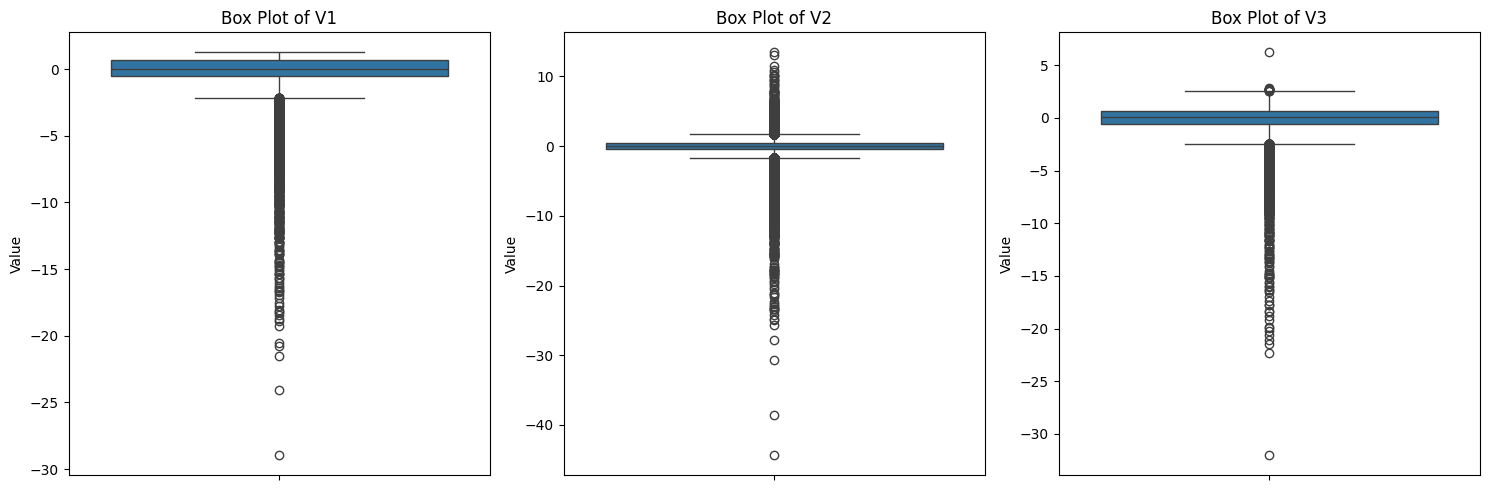

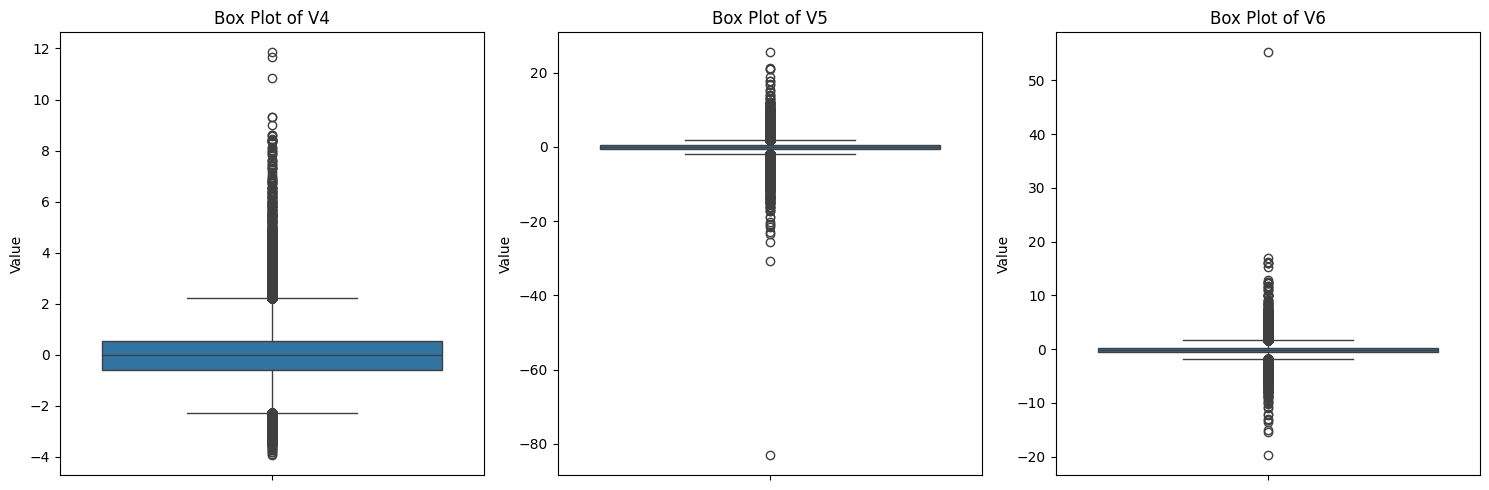

In [18]:
def plot_multiple_boxplots(feature_list, data):
    """
    Plots box plots for multiple features in the dataset.
    
    Parameters:
    - feature_list (list): List of feature names to plot.
    - data (DataFrame): The dataset (assumed to be X_train).
    
    Excludes 'Time' and 'Amount' from consideration.
    Displays plots in groups of three features at a time.
    """
    # Filter out excluded features
    valid_features = [f for f in feature_list if f not in ["Time", "Amount"] and f in data.columns]

    if not valid_features:
        print("No valid features to plot.")
        return

    # Plot in batches of three
    for i in range(0, len(valid_features), 3):
        batch = valid_features[i:i+3]
        num_plots = len(batch)

        plt.figure(figsize=(5 * num_plots, 5))
        
        for j, feature in enumerate(batch, 1):
            plt.subplot(1, num_plots, j)
            sns.boxplot(y=data[feature])
            plt.title(f"Box Plot of {feature}")
            plt.ylabel("Value")
        
        plt.tight_layout()
        plt.show()

# Example Usage:
feature_subset = ["V1", "V2", "V3", "V4", "V5", "V6"]  # Replace with the desired feature names
plot_multiple_boxplots(feature_subset, X_train)

### Checking Skewness of V1  

Before drawing conclusions about the asymmetry observed in `V1`, we must **formally test for skewness**.  

#### Why Check for Skewness?  
- **Visual inspection is not enough**—while the box plot showed an extended lower whisker, we need a numerical measure to confirm whether the distribution is **statistically skewed**.  
- **Skewness quantifies asymmetry**—a negative skewness score indicates a **longer tail on the left (negative side)**, while a positive score suggests a **longer right tail**.  

#### Steps for Skewness Testing 
1. **Compute the skewness score** for `V1`.  
2. **Interpret the result**:  
   - If **skewness < -1**, the distribution is **highly negatively skewed**.  
   - If **-1 < skewness < -0.5**, the distribution is **moderately negatively skewed**.  
   - If **-0.5 < skewness < 0.5**, the distribution is **approximately symmetric**.  

3. **Implications for Fraud Detection**  
   - If `V1` is **highly skewed**, we may need to consider **transformations** (e.g., log transformation) or handle outliers differently.  
   - If the skewness score is negligible, the earlier box plot observations might have **overstated the visual asymmetry**.  

Once the skewness test is completed, we will determine whether further adjustments are necessary for `V1` in fraud detection modeling.
